# Extended Kalman Filter

Use uncertain information (sensor data) and knowledge of how the system behaves (educated guess) to understand the state of a system which is continuously changing

eg, combine
- an intermittent and imprecise GPS signal
- prediction of what will _probably_ happen when you enter a certain input, such as 'forward'
- noisey but high frequency sensor data from an IMU

to get a very accurate estimate of the current position and velocity of a system

KF assumes that the variables are random and Gaussian distributed with a mean value $\mu$ and variance/uncertainty $\sigma^2$. However, KF relies on the fact that the variables involved are related in some way - eg. position and velocity

Following a guide from https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/ . Equation numbers correspond with this guide

## The State Estimate

$$ x_k = \begin{bmatrix} \theta \\ \dot{\theta} \end{bmatrix} $$

where $\theta$ is the absolute angle to the object

## The Covariance Matrix

$$ P = \begin{bmatrix} \Sigma_{pp} & \Sigma_{pv} \\ \Sigma_{vp} & \Sigma_{vv} \end{bmatrix}$$

where $ \Sigma_{ij} $ is the degree of variance between the _i'th_ and _j'th_ state variable.

## The Prediction Matrix, Control Matrix and Control Vector

Indicates how we move from one state to the next

$$ p_k = p_{k-1} + \Delta t v_{k-1} + \frac{1}{2} a \Delta t^2 $$
$$ v_k = v_{k-1} + a \Delta t$$

Thus,

$$ \begin{split} \hat{x}_k &= \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}\hat{x}_{k-1} + \begin{bmatrix} \frac{\Delta t^2}{2} \\ \Delta t \end{bmatrix} a \\ &= F_k\ \hat{x}_{k-1} + B_k\ u_k \end{split} $$

where $F_k$ is the prediction matrix, $B_k$ is the control matrix, and $u_k$ is the control vector

$B$ and $u$ represented tracked external influences

In other words, the new best estimate is a prediction made from the previous best estimate, plus a correction for known external influences

## Factoring in Uncertainty

Eg. uncertainty from modelling, noise, etc

Update the prediction matrix as follows,

$$ P_k = F_k\ P_{k-1}\ F_k^T + Q_k$$

In other words, the new uncertainty is predicted from the old uncertainty, with some additional uncertainty from the environment

## The Sensor Uncertainty Matrix

$$ \mu_{expected} = H_k\ \hat{x}_k $$
$$ \Sigma_{expected} = H_k\ P_k\ H_k^T $$
$$ y = z - h(x) $$

where $H_k$ is a matrix which models the sensors

In [3]:
import numpy as np
# import matplotlib.pyplot as plt

In [231]:
class ExtendedKalmanFilter():
    """
        x       the state estimate, θ and θ_dot
        P       the covariance matrix
        F       the prediction matrix
        Q       the [xxxxx] uncertainty matrix
        R       the [xxxxx] uncertainty matrix
        K       the Kalman gain matrix
    """
    def __init__(self, Ts=0.1, Q=5, R=1, camera_FOV_deg=62.2):
        self.Ts = Ts
        
        self.x = np.array([0, 0])
        self.P = 100*np.eye(2)
        self.F = np.array([[1, Ts],
                           [0,  1]])
        self.Q = Q
        self.R = R
        self.camera_FOV_rad = np.deg2rad(camera_FOV_deg)
        
        
    def predict(self):
        """
            get from x[k-1] to x[k] by using knowledge of how the system behaves 
            x = F*x
            P = F*P*F' + Q
        """
        self.x = self.F @ self.x
#         print(f'before: self.P = {self.P}')
        self.P = (self.F @ self.P @ self.F.T) #+ np.array([[self.Q, 0], [0, self.Q/10]])
#         self.P = (self.F @ self.P @ self.F.T) + self.Q
#         self.P = (self.F @ self.P @ self.F.T) + np.eye(2)*self.Q
#         print(f'after: self.P = {self.P}')
    
    
    def update(self, z):
        """
            get from x[k] to the best possible estimate of the system by using sensor data
            y = z - h(x)
            K = P*H' * inv(H*P*H' + R)
            x = x + K*(z - H*x)
            P = P - K*H*P
            
            where z = the pixel position, scaled from -1 (pixel 0) to 1 (end pixel)
        """
        y = z - self.h(self.x)
        _h_dash = self.h_dash(self.x)
        H = np.array([_h_dash, 0])
        
        K = (self.P @ H.T) /(H @ self.P @ H.T + self.R)
        self.x = self.x  +  K * y
#         print(f'before: self.P = {self.P}')
        self.P = (np.eye(2) - K @ H) @ self.P
#         print(f'after: self.P = {self.P}')
    
    def h(self, x):
        """ convert from angle to pixel
        x is the pixel value [-1, 1]
        cam_angle is the angular size of the camera along that dimension """
        return x[0]#np.tan(x[0]) / np.tan(self.camera_FOV_rad/2)
    
    def h_dash(self, x):
        return 1#(1/np.cos(x[0]))**2 / np.tan(self.camera_FOV_rad/2)

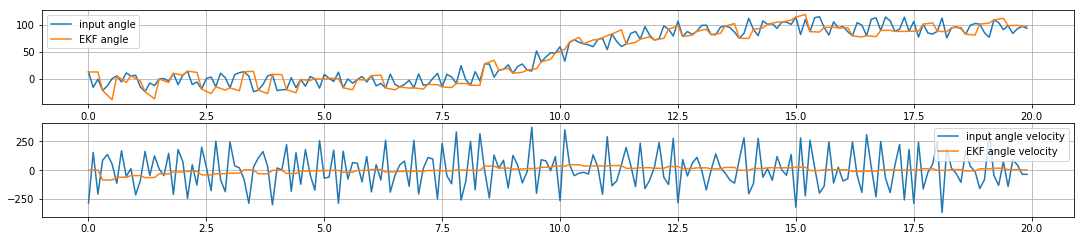

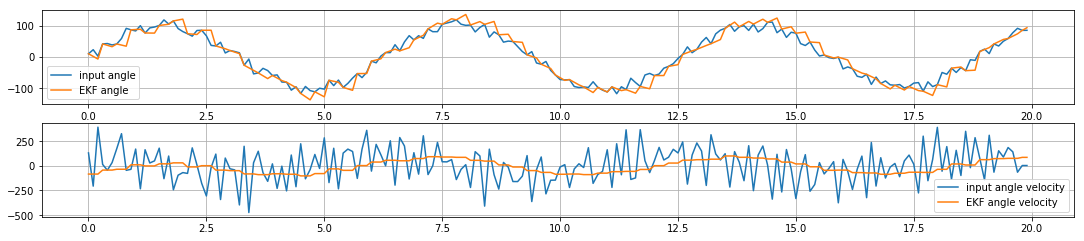

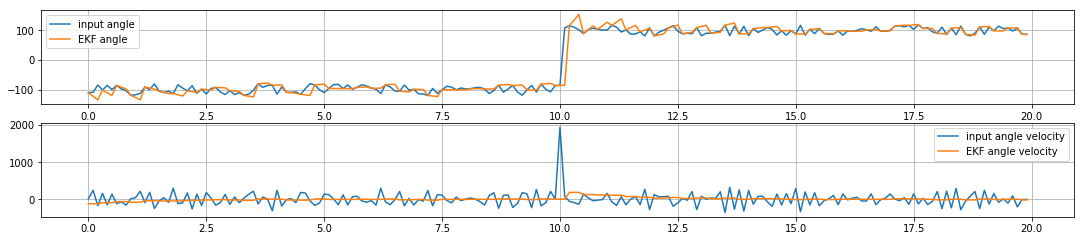

In [266]:
EKF = ExtendedKalmanFilter(Ts=0.1, Q=0.5, R=1.5)

def noise(scale): return (np.random.random() - 0.5)*scale
def ref_sin(t, sim_time): return 100*np.sin(t) + noise(40)
def ref_step(t, sim_time): return -100 + 200*(t > sim_time/2) + noise(40)
def ref_sigmoid(t, sim_time): return 100/(1 + 3**(-t + sim_time/2)) - 5 + noise(40)

P_sig = sim_and_plot_EKF(EKF, ref_sigmoid, T_nn=0.3, sim_time=20)
P_sin = sim_and_plot_EKF(EKF, ref_sin, T_nn=0.3, sim_time=20)
P_step = sim_and_plot_EKF(EKF, ref_step, T_nn=0.3, sim_time=20)

# angle += (np.random.random() - 0.5)/2
# if len(angle_arr) > 0: angle = (angle + angle_arr[-1])/2

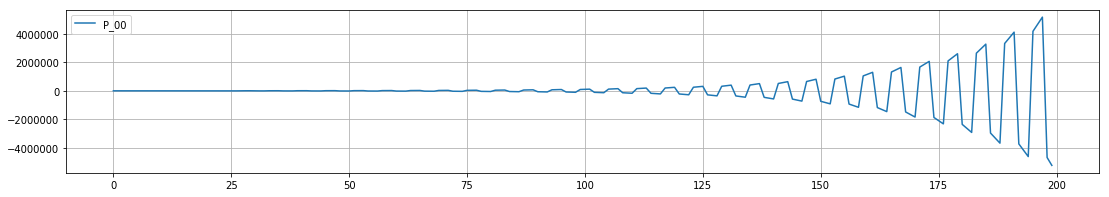

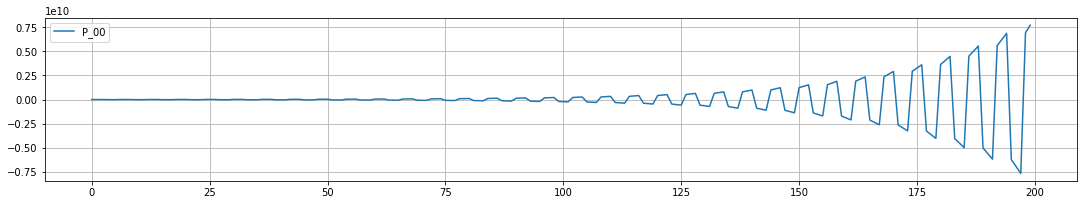

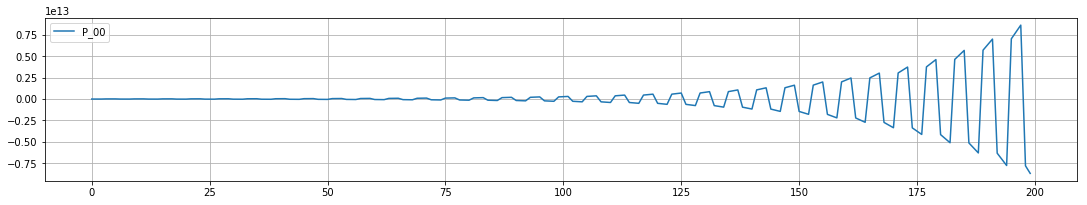

In [263]:
plot_P_matrix(P_sig)
plot_P_matrix(P_sin)
plot_P_matrix(P_step)

In [264]:
def sim_and_plot_EKF(EKF, angle_func, sim_time=10, T_nn=0.3):
    x_arr, x_dot_arr, angle_arr, t_arr = [], [], [], []
    P_00_arr, P_01_arr, P_10_arr, P_11_arr = [], [], [], []
    angle = 0

    for t in np.arange(0, sim_time, 0.1):
        t_arr.append(t)

        angle = angle_func(t, sim_time)

        if (t % T_nn < 0.01) or -0.01 < abs(t % T_nn) - T_nn < 0.01: EKF.update(angle)
        else: EKF.predict()

        x_arr.append(EKF.x[0])
        x_dot_arr.append(EKF.x[1])
        angle_arr.append(angle)

        P = EKF.P
        P_00_arr.append(P[0][0]); P_01_arr.append(P[0][1]); P_10_arr.append(P[1][0]); P_11_arr.append(P[1][1])


    plt.subplot(211)
    plt.plot(t_arr, angle_arr, label='input angle')
    plt.plot(t_arr, x_arr, label='EKF angle')
    plt.legend(); plt.grid()

    plt.subplot(212)
    angle_dot_arr = [(x - y)/0.1 for x, y in zip(angle_arr[1:], angle_arr[0:-1])]  # need to divide by dt
    angle_dot_arr.append(angle_dot_arr[-1])
    plt.plot(t_arr, angle_dot_arr, label='input angle velocity')
    plt.plot(t_arr, x_dot_arr, label='EKF angle velocity')
    plt.legend(); plt.grid()

    fig = plt.gcf(); fig.set_size_inches(18.5, 3.8, forward=True)

    plt.show()
    
    return (P_00_arr, P_01_arr, P_10_arr, P_11_arr)


def plot_P_matrix(P):
    (P_00_arr, P_01_arr, P_10_arr, P_11_arr) = P
    
    plt.subplot(111); plt.plot(P_00_arr, label='P_00'); plt.legend(); plt.grid()
    #plt.subplot(412); plt.plot(P_01_arr, label='P_01'); plt.legend(); plt.grid()
    #plt.subplot(413); plt.plot(P_10_arr, label='P_10'); plt.legend(); plt.grid()
    #plt.subplot(414); plt.plot(P_11_arr, label='P_11'); plt.legend(); plt.grid()
    fig = plt.gcf(); fig.set_size_inches(18.5, 3, forward=True); plt.show()